In [1]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import pickle as pkl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm

from metrics import kernel_noise, kernel_error, dist_var, bias_estimator

In [2]:
phi_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize(299),
    transforms.CenterCrop(299),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.data[index]


def create_dataset(dataset_name, image_size, workers=8, subset=0, load_dataset_in_memory=False, type="train", flatten=False, use_phi=False):
    data_phi = None
    if dataset_name == "PathMNIST":
        from medmnist import PathMNIST
        data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                (0.5, 0.5, 0.5),
                (0.5, 0.5, 0.5)
            )
        ])
        dataset = PathMNIST(
            split=type,
            transform=data_transform,
            download=True
        )
    elif dataset_name == "ChestMNIST":
        from medmnist import ChestMNIST
        data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        dataset = ChestMNIST(
            split=type,
            transform=data_transform,
            download=True
        )
    else:
        dataset = dset.ImageFolder(
            root=f"Rebuttal/{dataset_name}/{type}/",
            transform=transforms.Compose([
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        )
    if subset != 0:
        dataset = torch.utils.data.Subset(
            dataset,
            np.random.choice(
                len(dataset),
                subset,
                replace=False
            )
        )
    if load_dataset_in_memory:
        dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=128, shuffle=True, num_workers=workers
        )
        data_list = []
        data_phi_list = []
        print("loading all images")
        for image in tqdm(dataloader):
            if use_phi:
                data_phi_list.append(phi(image[0]))
            data_list.append(image[0])
        data = []
        data_phi = []
        print("stacking all images")
        for batch in tqdm(data_list):
            if flatten:
                data += list(batch.reshape(batch.shape[0], -1))
            else:
                data += list(batch)
        if use_phi:
            for batch in data_phi_list:
                data_phi += list(batch.detach().numpy())
            data_phi = np.array(data_phi)

        dataset = torch.stack(data)

        dataset = CustomDataset(dataset)

    if use_phi:
        return dataset, data_phi
    return dataset

def phi(tests):
    inception_model = models.inception_v3(pretrained=True)
    inception_model.eval()
    return inception_model(phi_transform(torch.tensor(tests)))

In [3]:
celeba = create_dataset("celeba", 64, load_dataset_in_memory=False, type="test")

In [4]:
torch.manual_seed(0)
np.random.seed(0)
n_test = 500
subset = torch.utils.data.Subset(
    celeba,
    np.random.choice(len(celeba), n_test, replace=False)
)
testset = torch.empty((n_test, 3, 64, 64))
for (i, (x, y)) in enumerate(subset):
    testset[i] = x
testset.shape

torch.Size([500, 3, 64, 64])

In [5]:
ys = testset.flatten(-3)
ys.shape

torch.Size([500, 12288])

In [6]:
# training was done in a different environment and including this environment here would add too much files for little gain
# I can provide models and the following file upon request
with open(r"Rebuttal/DCGAN samples batch_size=128 ngf=64 ndf=64 lr=0.0002 beta1=0.5.pkl",'rb') as file:
    generations = torch.from_numpy(pkl.load(file))

In [7]:
generations.shape

torch.Size([51, 20, 20, 3, 64, 64])

In [8]:
xs_gen = generations.flatten(-3)
xs_gen.shape

torch.Size([51, 20, 20, 12288])

In [39]:
epochs = range(xs_gen.shape[0])
ens_ids = range(xs_gen.shape[1])
kernel_str = 'lap_kernel'
kernel = lambda x,y: metrics.pairwise.laplacian_kernel(x, y)
estimates_per_epoch = {'Var': [], 'Epoch': [], 'GE': [], 'Noise': [], 'Bias': [], 'GE ens': [], 'GE 5 ens': []}
noise = kernel_noise(ys)
for epoch in tqdm(epochs, total=len(epochs), desc='Epochs', leave=False):
    var = dist_var(xs_gen[epoch], kernel=kernel)
    bias = bias_estimator(xs_gen[epoch], ys, kernel=kernel)
    # predictive kernel entropy of the first model
    pred_k_ent = kernel_noise(xs_gen[epoch, 0], kernel=kernel)
    errors = [kernel_error(xs_gen[epoch, n], ys, kernel=kernel) for n in ens_ids]
    # ensemble error
    ens_error = kernel_error(xs_gen[epoch].flatten(0,1), ys, kernel=kernel)
    
    estimates_per_epoch['GE'].append(np.mean(errors))
    estimates_per_epoch['GE ens'].append(ens_error)
    estimates_per_epoch['Noise'].append(noise)
    estimates_per_epoch['Var'].append(var)
    estimates_per_epoch['Bias'].append(bias)
    estimates_per_epoch['Epoch'].append(epoch)
estimates_per_epoch = pd.DataFrame(estimates_per_epoch)

In [40]:
sub_estimates = estimates_per_epoch.copy()
sub_estimates['Epoch'] += 1
sub_estimates.index = sub_estimates['Epoch']
sub_estimates = sub_estimates[sub_estimates['Epoch'].isin(range(1, 34, 2))]
sub_estimates['MMD'] = sub_estimates['GE'] - sub_estimates['Noise']
sub_estimates['MMD ens'] = sub_estimates['GE ens'] - sub_estimates['Noise']
sub_estimates['MMD-Var'] = sub_estimates['MMD'] - sub_estimates['Var']
sub_estimates

,Var,Epoch,GE,Noise,Bias,GE ens,GE 5 ens,MMD,MMD ens,MMD 5 ens,MMD-Var
Epoch,,,,,,,,,,,
1,0.001641,1,-0.198552,-0.575633,0.375441,-0.200114,-0.199780,0.377081,0.375519,0.375853,0.375441
3,0.009721,3,-0.544237,-0.575633,0.021675,-0.553495,-0.554147,0.031396,0.022138,0.021486,0.021675
5,0.003517,5,-0.551450,-0.575633,0.020667,-0.554799,-0.556181,0.024183,0.020834,0.019452,0.020667
7,0.001491,7,-0.554208,-0.575633,0.019934,-0.555628,-0.556529,0.021425,0.020005,0.019104,0.019934
9,0.002304,9,-0.544304,-0.575633,0.029025,-0.546498,-0.539745,0.031329,0.029135,0.035888,0.029025
11,0.000972,11,-0.546113,-0.575633,0.028549,-0.547038,-0.541399,0.029520,0.028595,0.034234,0.028549
13,0.001595,13,-0.547739,-0.575633,0.026298,-0.549259,-0.543601,0.027894,0.026374,0.032033,0.026298
15,0.001034,15,-0.549738,-0.575633,0.024861,-0.550723,-0.547189,0.025895,0.024910,0.028445,0.024861
17,0.001122,17,-0.549756,-0.575633,0.024755,-0.550825,-0.548199,0.025877,0.024808,0.027434,0.024755


In [41]:
#sub_estimates[sub_estimates['Epoch'].isin(range(1, 34, 4))]['Bias']+sub_estimates[sub_estimates['Epoch'].isin(range(1, 34, 4))]['Var']
sub_estimates[sub_estimates['Epoch'].isin(range(1, 34, 4))]['GE']

Epoch
1    -0.198552
5    -0.551450
9    -0.544304
13   -0.547739
17   -0.549756
21   -0.550572
25   -0.537976
29   -0.533542
33   -0.546834
Name: GE, dtype: float64

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_5488/2391677455.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


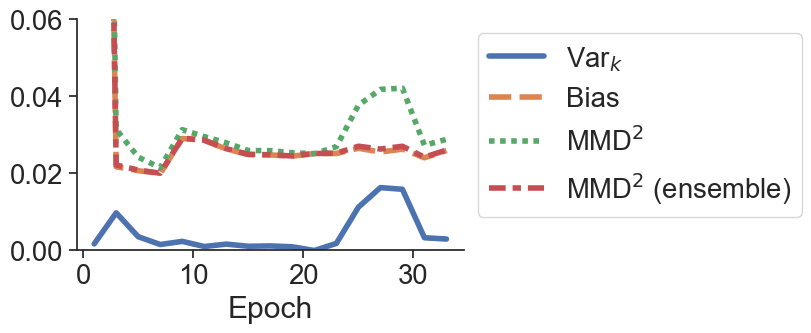

In [43]:
# Figure 13 Right
sns.set(font_scale=1.8)
sns.set_style('ticks')
plt.figure(figsize=(5, 3))
line_size = 4
sub_estimates[['Var$_k$', 'Bias', 'MMD$^2$', 'MMD$^2$ (ensemble)']] = sub_estimates[['Var', 'Bias', 'MMD', 'MMD ens']]
#sub_results.index = range(0, 52, 2)
plot = sns.lineplot(data=sub_estimates[['Var$_k$', 'Bias', 'MMD$^2$', 'MMD$^2$ (ensemble)']], linewidth=line_size)
plot.set(xlabel='Epoch', ylim=(0,0.06))
sns.despine()
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
save_name = f'plots/bias_var_mmd_per_epoch_celeba_{kernel_str}'
plot.figure.savefig(save_name+'.pdf', bbox_inches='tight')
plot.figure.savefig(save_name+'.png', bbox_inches='tight')
plot.figure.show();

In [52]:
# same functions as in infimnist_cond_ddpm.ipynb
def single_simulation(seed, rng, ens_ids, n_samp, xs_gen, exp_dict, kernel):
    # writes to exp_dict as side-effect
    max_samp = xs_gen.shape[1]
    samp_ids = rng.choice(max_samp, n_samp, replace=False)
    sub_sample = xs_gen[ens_ids,:,:][:,samp_ids,:,]

    exp_dict['Seed'].append(seed)
    exp_dict['n_ens'].append(len(ens_ids))
    exp_dict['n_samp'].append(n_samp)
    exp_dict['dist_var'].append(dist_var(sub_sample, kernel=kernel))

def estimator_simulation(
    xs_gen, seeds=range(5000), n_enss=range(2, 16), n_samps=range(2, 16), rep_ens=True,
    kernel=lambda x, y: metrics.pairwise.rbf_kernel(x, y, gamma=None)
):
    max_ens = xs_gen.shape[0]
    exp_results = {
        'Seed': [],
        'n_ens': [],
        'n_samp': [],
        'dist_var': [],
    }
    if rep_ens:
        for seed in tqdm(seeds, total=len(seeds), desc='Seeds'):
            rng = np.random.default_rng(seed=seed)
            for n_ens in n_enss:
                for n_samp in n_samps:
                    ens_ids = rng.choice(max_ens, n_ens, replace=False)
                    single_simulation(
                        seed, rng, ens_ids, n_samp, xs_gen, exp_results, kernel
                    )
    else:
        # we do not resample the ensemble, so just set one seed
        rng = np.random.default_rng(seed=0)
        for n_ens in tqdm(n_enss, total=len(n_enss), desc='Ensembles'):
            ens_ids = rng.choice(max_ens, n_ens, replace=False)
            for seed in seeds:
                rng = np.random.default_rng(seed=seed)
                for n_samp in n_samps:
                    single_simulation(
                        seed, rng, ens_ids, n_samp, xs_gen, exp_results, kernel
                    )
    return pd.DataFrame(exp_results)


In [63]:
prev_reps = 0
reps = 1000
epoch = 27
seeds = range(prev_reps, prev_reps+reps)
kernel = lambda x, y: metrics.pairwise.laplacian_kernel(x, y)
kernel_str = 'lap_kernel'
# evaluate epoch `epoch`
estimation_results = estimator_simulation(xs_gen[epoch-1], seeds=seeds, kernel=kernel)
# evaluate all epochs
#estimation_results = estimator_simulation(xs_gen.flatten(0, 1), seeds=seeds, kernel=kernel)
estimation_results.to_csv('results/estimator_simulation_celeba_{}_seeds{}-{}_epoch{}.csv'.format(kernel_str, prev_reps, prev_reps+reps, epoch))

Seeds: 100%|██████████████████████████████| 1000/1000 [2:42:37<00:00,  9.76s/it]


/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_3772/1338410211.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


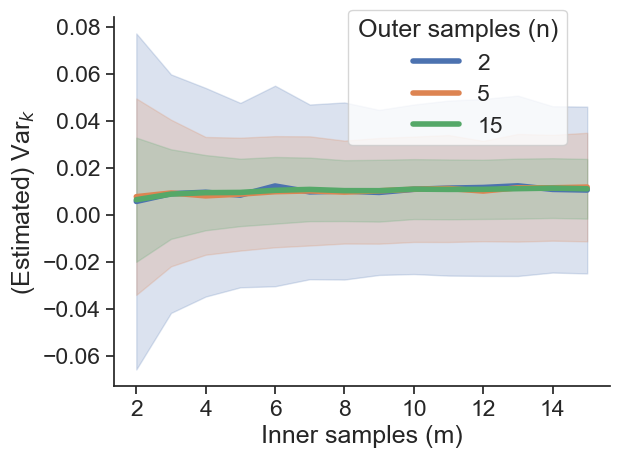

In [106]:
# Figure used in the rebuttal
epoch = 33
#estimation_results = pd.read_csv(f'results/estimator_simulation_celeba_lap_kernel_seeds0-1000_epoch{epoch}.csv', index_col=0)
estimation_results = pd.read_csv(f'results/estimator_simulation_celeba_lap_kernel_seeds100-2100.csv', index_col=0)
sub_results = estimation_results[estimation_results['n_ens'].isin([2, 5, 15])]
sns.set(font_scale=1.5)
sns.set_style('ticks')
line_size = 4
plot = sns.lineplot(data=sub_results, x='n_samp', y='dist_var', hue='n_ens', errorbar='sd', palette=sns.color_palette()[0:3], linewidth=line_size)
plot.axes.set_xticks([2, 4, 6, 8, 10, 12, 14])
plot.set(ylabel='(Estimated) Var$_k$', xlabel='Inner samples (m)')
leg = plot.legend(title='Outer samples (n)')
for line in leg.get_lines():
    line.set_linewidth(4)
sns.move_legend(plot, "upper left", bbox_to_anchor=(0.45, 1.05))
sns.despine()
#save_name = f'plots/sim_var_celeba_{kernel_str}_epoch{epoch}'
save_name = f'plots/sim_var_celeba_{kernel_str}_noniid'
plot.figure.savefig(save_name+'.pdf', bbox_inches='tight')
plot.figure.savefig(save_name+'.png', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_58389/2319479986.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(np.transpose(vutils.make_grid(torch.tensor(generations[epoch, 0:8, 0:8].flatten(0,1)), padding=2, normalize=True).cpu(),(1,2,0)))


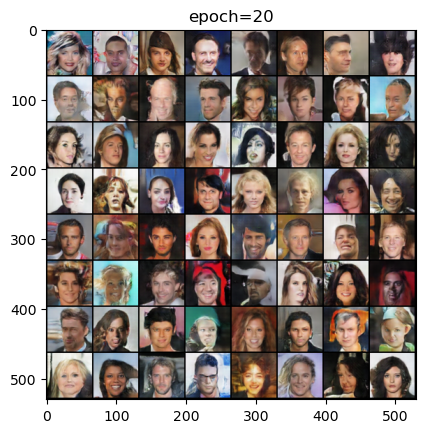

In [9]:
### Figure 13 Left
import torchvision.utils as vutils
epoch = 20
plt.imshow(np.transpose(vutils.make_grid(torch.tensor(generations[epoch, 0:8, 0:8].flatten(0,1)), padding=2, normalize=True).cpu(),(1,2,0)))
plt.title(f"{epoch=}")
#plt.savefig(f'plots/celebA_gen_epoch{epoch}.png', bbox_inches='tight')
plt.savefig(f'plots/celebA_gen_epoch{epoch}.pdf', bbox_inches='tight')
plt.show();